Epoch 1/40


C:\Users\Zelin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2501/2501 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0085 - auc: 0.9244 - fn: 249402.4062 - fp: 2.4305 - loss: 0.0138 - recall: 0.4628 - tn: 4061.4304 - tp: 227109.2969 - val_accuracy: 0.0084 - val_auc: 0.9944 - val_fn: 123397.0000 - val_fp: 1.0000 - val_loss: 5.0399e-05 - val_recall: 0.4815 - val_tn: 1997.0000 - val_tp: 114611.0000
Epoch 2/40
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0085 - auc: 0.9941 - fn: 247683.1719 - fp: 2.7710 - loss: 4.2338e-05 - recall: 0.4801 - tn: 4041.2666 - tp: 228848.3438 - val_accuracy: 0.0084 - val_auc: 0.9938 - val_fn: 123692.0000 - val_fp: 1.0000 - val_loss: 4.4669e-05 - val_recall: 0.4803 - val_tn: 1997.0000 - val_tp: 114316.0000
Epoch 3/40
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0086 - auc: 0.9935 - fn: 247717.1875 - fp: 3.0492 - loss: 3.5156e-05 - recall: 0.4803 - tn: 4067.3662 - tp: 228787.9531 - val_accuracy: 0.0084 - val_auc: 0.9936 - val_fn: 123843.0000 - val_fp: 1.0000 - val_loss: 4.4067e-05 - val_recall: 0.

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step


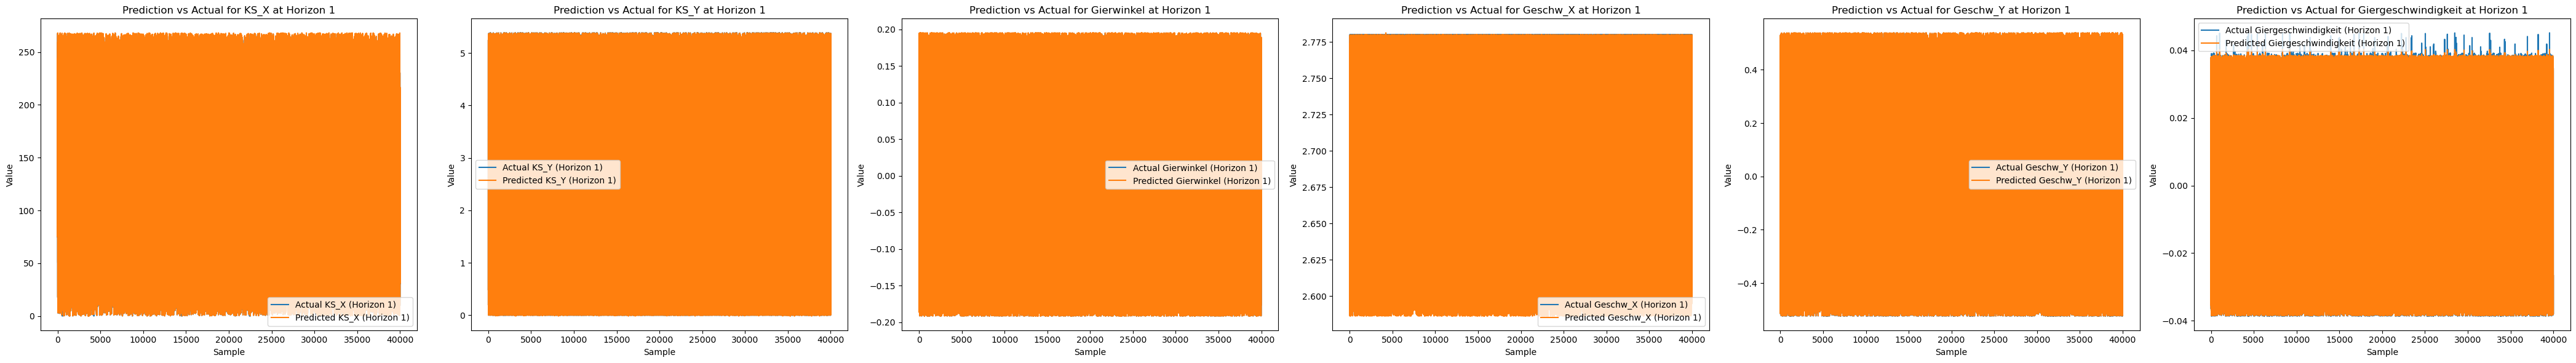

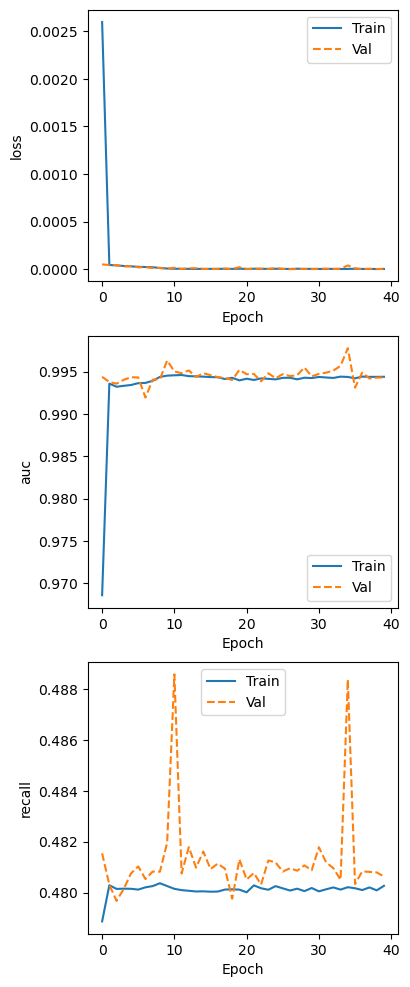

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import keras



def merge_csv_files(directory, Import_csv_file):
    # 存储所有DataFrame的列表
    df_list = []
    # 遍历目录
    # for filename in os.listdir(directory):
        # if filename.endswith('.csv'):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == Import_csv_file:
                # 读取CSV文件
                df = pd.read_csv(os.path.join(root, file))
                df_list.append(df)

    # 合并所有DataFrame
    merged_df = pd.concat(df_list, ignore_index=True)
    return merged_df

# 使用函数
directory_path = './data'  # 指定目录路径
Import_csv_file = 'Importdata_4ms.csv'  # 合并后的Import CSV文件名
Exoport_csv_file = 'Exportdata_4ms.csv'  # 合并后的Import CSV文件名
Import_merged_data = merge_csv_files(directory_path, Import_csv_file)
Exoport_merged_data = merge_csv_files(directory_path, Exoport_csv_file)
merged_data = pd.merge(Import_merged_data, Exoport_merged_data, left_index=True, right_index=True)

# 获取表头
headers = merged_data.columns.tolist()

# # 选择输入和输出列
X = merged_data[headers[1:6]].values  # 输入列
y = merged_data[headers[7:14]].values  # 输出列

# 归一化数据
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 将数据转换为LSTM所需的时间步格式
def create_dataset(X, y, time_step=5, forecast_horizon=1):
    X_data, y_data = [], []
    for i in range(len(X) - time_step - forecast_horizon + 1):
        # 确保 y[i:(i + time_step)] 和 X[i + time_step] 维度一致
        input_y = y[i:(i + time_step)]  # (time_step, y_features)
        input_x = X[i + time_step].reshape(1, -1)  # (1, x_features)
        
        # 如果输入维度不同，则进行补齐或选择相同维度
        if input_y.shape[1] != input_x.shape[1]:
            min_features = min(input_y.shape[1], input_x.shape[1])
            input_y = input_y[:, :min_features]  # 截断y
            input_x = input_x[:, :min_features]  # 截断X

        # 拼接过去time_step步y和当前步X
        input_data = np.vstack((input_y, input_x))  # (time_step + 1, features)
        X_data.append(input_data)

        # 目标数据：预测未来 forecast_horizon 个目标值
        y_data.append(y[i + time_step:i + time_step + forecast_horizon])

    return np.array(X_data), np.array(y_data)
time_step = 5  # 输入时间步数
forecast_horizon = 1  # 预测1个未来时间步
X_data, y_data = create_dataset(X_scaled, y_scaled, time_step, forecast_horizon)

# 拆分数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)

# 创建LSTM模型
model = Sequential()
model.add(LSTM(
    units=50,
    return_sequences=False,
    input_shape=(time_step, X_train.shape[2])
))

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.add(Dense(units=forecast_horizon * 6))  # 输出多个时间步
model.compile(optimizer='adam', loss='mean_squared_error', metrics=METRICS)

# 训练模型并保存训练历史
history = model.fit(
    X_train,
    y_train.reshape(-1, forecast_horizon * 6),
    epochs=40,
    batch_size=64,
    validation_data=(X_test, y_test.reshape(-1, forecast_horizon * 6))
)

model.save('./predict_model.h5')

# 预测结果
y_pred = model.predict(X_test)

# 反归一化数据
# 由于y_pred和y_test有forecast_horizon * 6个特征，需要先重塑形状再进行反归一化
y_pred_reshaped = y_pred.reshape(-1, 6)  # (samples * forecast_horizon, 6)
y_test_reshaped = y_test.reshape(-1, 6)

y_pred_rescaled = scaler_y.inverse_transform(y_pred_reshaped).reshape(y_pred.shape[0], forecast_horizon,6)
y_test_rescaled = scaler_y.inverse_transform(y_test_reshaped).reshape(y_test.shape[0], forecast_horizon, 6)

# 可视化结果
plt.figure(figsize=(42, 6))  # 增加宽度和高度以适应多个子图
feature_names = headers[7:14]

for i in range(forecast_horizon):
    for j in range(6):  # Iterate over each feature
        plt.subplot(forecast_horizon, 6, i * 6 + j + 1)
        plt.plot(y_test_rescaled[:, i, j], label=f'Actual {feature_names[j]} (Horizon {i+1})')
        plt.plot(y_pred_rescaled[:, i, j], label=f'Predicted {feature_names[j]} (Horizon {i+1})')
        plt.legend()
        plt.title(f'Prediction vs Actual for {feature_names[j]} at Horizon {i+1}')
        plt.xlabel('Sample')
        plt.ylabel('Value')

plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 12))
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'recall']
    for n, metric in enumerate(metrics):
        name = metric
        plt.subplot(3,1,n+1)
        plt.plot(history.epoch,  history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim()
        elif metric == 'auc':
            plt.ylim()
        else:
            plt.ylim()

        plt.legend()
plot_metrics(history)